In [29]:
import warnings
warnings.filterwarnings("ignore")

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor

In [31]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_absolute_percentage_error as mape

In [32]:
df = pd.read_csv('delivery_train.csv')

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45593 entries, 0 to 45592
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           45593 non-null  object 
 1   Delivery_person_ID           45593 non-null  object 
 2   Delivery_person_Age          45593 non-null  object 
 3   Delivery_person_Ratings      45593 non-null  object 
 4   Restaurant_latitude          45593 non-null  float64
 5   Restaurant_longitude         45593 non-null  float64
 6   Delivery_location_latitude   45593 non-null  float64
 7   Delivery_location_longitude  45593 non-null  float64
 8   Order_Date                   45593 non-null  object 
 9   Time_Orderd                  45593 non-null  object 
 10  Time_Order_picked            45593 non-null  object 
 11  Weatherconditions            45593 non-null  object 
 12  Road_traffic_density         45593 non-null  object 
 13  Vehicle_conditio

In [34]:
df.shape

(45593, 20)

In [35]:
df.describe(exclude=np.number).T

,count,unique,top,freq
ID,45593,45593,0x4607,1
Delivery_person_ID,45593,1320,PUNERES01DEL01,67
Delivery_person_Age,45593,23,35,2262
Delivery_person_Ratings,45593,29,4.8,7148
Order_Date,45593,44,15-03-2022,1192
Time_Orderd,45593,177,NaN,1731
Time_Order_picked,45593,193,21:30:00,496
Weatherconditions,45593,7,conditions Fog,7654
Road_traffic_density,45593,5,Low,15477
Type_of_order,45593,4,Snack,11533


In [36]:
df.rename(columns={'Weatherconditions': 'Weather_conditions'},inplace=True)
df.rename(columns={'City': 'city_type'},inplace=True)

In [37]:
def extract_column_values(df):
    #Extract time and convert to int
    df['Time_taken(min)'] = df['Time_taken(min)'].apply(lambda x: int(x.split(' ')[1].strip()))
    #Extract Weather conditions
    df['Weather_conditions'] = df['Weather_conditions'].apply(lambda x: x.split(' ')[1].strip())
    #Extract city code from Delivery person ID
    df['City_code']=df['Delivery_person_ID'].str.split("RES", expand=True)[0]
    
extract_column_values(df)
df.head()

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,...,Weather_conditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,city_type,Time_taken(min),City_code
0,0x4607,INDORES13DEL02,37,4.9,22.745049,75.892471,22.765049,75.912471,19-03-2022,11:30:00,...,Sunny,High,2,Snack,motorcycle,0,No,Urban,24,INDO
1,0xb379,BANGRES18DEL02,34,4.5,12.913041,77.683237,13.043041,77.813237,25-03-2022,19:45:00,...,Stormy,Jam,2,Snack,scooter,1,No,Metropolitian,33,BANG
2,0x5d6d,BANGRES19DEL01,23,4.4,12.914264,77.678400,12.924264,77.688400,19-03-2022,08:30:00,...,Sandstorms,Low,0,Drinks,motorcycle,1,No,Urban,26,BANG
3,0x7a6a,COIMBRES13DEL02,38,4.7,11.003669,76.976494,11.053669,77.026494,05-04-2022,18:00:00,...,Sunny,Medium,0,Buffet,motorcycle,1,No,Metropolitian,21,COIMB
4,0x70a2,CHENRES12DEL01,32,4.6,12.972793,80.249982,13.012793,80.289982,26-03-2022,13:30:00,...,Cloudy,High,1,Snack,scooter,1,No,Metropolitian,30,CHEN


In [38]:
df.drop(['ID','Delivery_person_ID'],axis=1,inplace=True)

In [39]:
#replacing 'NAN' with np.nan
df.replace('NaN', float(np.nan), regex=True,inplace=True)     
df.isna().sum()

Delivery_person_Age            1854
Delivery_person_Ratings        1908
Restaurant_latitude               0
Restaurant_longitude              0
Delivery_location_latitude        0
Delivery_location_longitude       0
Order_Date                        0
Time_Orderd                    1731
Time_Order_picked                 0
Weather_conditions              616
Road_traffic_density            601
Vehicle_condition                 0
Type_of_order                     0
Type_of_vehicle                   0
multiple_deliveries             993
Festival                        228
city_type                      1200
Time_taken(min)                   0
City_code                         0
dtype: int64

In [40]:
#dropping nan values and checking for shape
df.dropna(inplace = True)
df.shape

(41368, 19)

In [41]:
#converting time date to appropriate format
df['Order_Date']=pd.to_datetime(df['Order_Date'],format="%d-%m-%Y")
df['Time_Orderd']=pd.to_timedelta(df['Time_Orderd'])
df['Time_Order_picked']=pd.to_timedelta(df['Time_Order_picked'])

In [42]:
#Extracting order prepare time
df['Time_Order_picked_formatted']=np.where(df['Time_Order_picked'] < df['Time_Orderd'], 
                        df['Order_Date'] + pd.DateOffset(1)+df['Time_Order_picked'], df['Order_Date']+df['Time_Order_picked'])
df['Time_Ordered_formatted'] = df['Order_Date'] + df['Time_Orderd']
df['prepare_time'] = (df['Time_Order_picked_formatted'] - df['Time_Ordered_formatted']).dt.total_seconds()/60

In [43]:
#Extracting if weekend feature
df['day_of_week'] = df['Order_Date'].dt.day_of_week.astype(int)
df['weekend'] = np.where(df['day_of_week'].isin([5,6]),1,0).astype('object')

In [44]:
#Extracting if month start and month end feature
df["month_start"] = df.Order_Date.dt.is_month_start.astype(int).astype(object)
df["month_end"] = df.Order_Date.dt.is_month_end.astype(int).astype(object)

In [45]:
#Dropping all unecessary time related columns
df.drop(['Time_Orderd','Time_Order_picked','Time_Ordered_formatted',
            'Time_Order_picked_formatted','day_of_week','Order_Date'],axis=1,inplace=True)

In [46]:
df.shape

(41368, 20)

In [47]:
# Set the earth's radius (in kilometers)
R = 6371

# Convert degrees to radians
def deg_to_rad(degrees):
    return degrees * (np.pi/180)

# Function to calculate the distance between two points using the haversine formula
def distcalculate(lat1, lon1, lat2, lon2):
    d_lat = deg_to_rad(lat2-lat1)
    d_lon = deg_to_rad(lon2-lon1)
    a = np.sin(d_lat/2)**2 + np.cos(deg_to_rad(lat1)) * np.cos(deg_to_rad(lat2)) * np.sin(d_lon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return R * c

In [48]:
# Calculate the distance between each pair of points
df['distance'] = np.nan

for i in range(len(df)):
    df['distance'].iloc[i] = distcalculate(df['Restaurant_latitude'].iloc[i], df['Restaurant_longitude'].iloc[i], 
    df['Delivery_location_latitude'].iloc[i], df['Delivery_location_longitude'].iloc[i]).round(2)

In [49]:
#Dropping all latitude and longitude related columns
df.drop(['Restaurant_latitude','Restaurant_longitude','Delivery_location_latitude',
            'Delivery_location_longitude'],axis=1,inplace=True)

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41368 entries, 0 to 45592
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Delivery_person_Age      41368 non-null  object 
 1   Delivery_person_Ratings  41368 non-null  object 
 2   Weather_conditions       41368 non-null  object 
 3   Road_traffic_density     41368 non-null  object 
 4   Vehicle_condition        41368 non-null  int64  
 5   Type_of_order            41368 non-null  object 
 6   Type_of_vehicle          41368 non-null  object 
 7   multiple_deliveries      41368 non-null  object 
 8   Festival                 41368 non-null  object 
 9   city_type                41368 non-null  object 
 10  Time_taken(min)          41368 non-null  int64  
 11  City_code                41368 non-null  object 
 12  prepare_time             41368 non-null  float64
 13  weekend                  41368 non-null  object 
 14  month_start           

In [51]:
df.Vehicle_condition = df.Vehicle_condition.astype('object')
df.Delivery_person_Ratings = df.Delivery_person_Ratings.astype('float64')
df.Delivery_person_Age = df.Delivery_person_Age.astype('int')

In [52]:
df.shape

(41368, 17)

In [53]:
df_num = df.select_dtypes(include="number")

# EDA

In [54]:
df_num.describe()

,Delivery_person_Age,Delivery_person_Ratings,Time_taken(min),prepare_time,distance
count,41368.000000,41368.000000,41368.000000,41368.000000,41368.000000
mean,29.610013,4.633209,26.553350,9.989243,26.912076
std,5.764152,0.315861,9.334363,4.086094,298.782065
min,20.000000,2.500000,10.000000,5.000000,1.470000
25%,25.000000,4.500000,19.000000,5.000000,4.660000
50%,30.000000,4.700000,26.000000,10.000000,9.270000
75%,35.000000,4.900000,33.000000,15.000000,13.740000
max,39.000000,5.000000,54.000000,15.000000,6884.730000


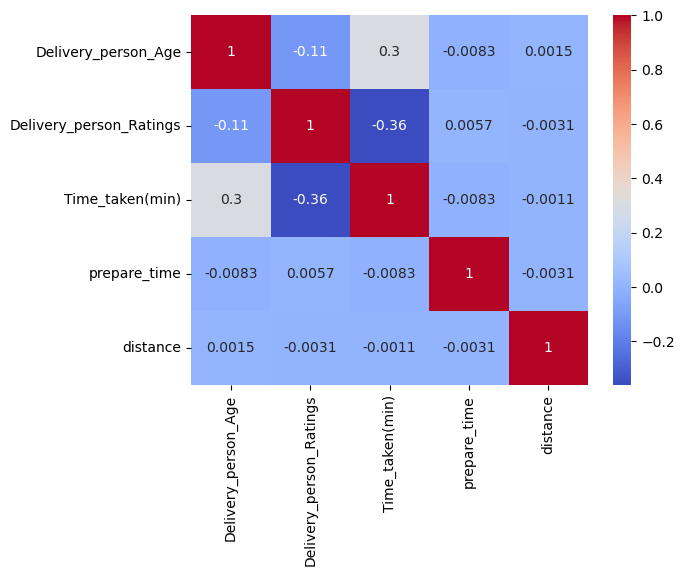

In [57]:
sns.heatmap(df_num.corr(), annot=True, cmap='coolwarm');

In [58]:
df.head()

,Delivery_person_Age,Delivery_person_Ratings,Weather_conditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,city_type,Time_taken(min),City_code,prepare_time,weekend,month_start,month_end,distance
0,37,4.9,Sunny,High,2,Snack,motorcycle,0,No,Urban,24,INDO,15.0,1,0,0,3.03
1,34,4.5,Stormy,Jam,2,Snack,scooter,1,No,Metropolitian,33,BANG,5.0,0,0,0,20.18
2,23,4.4,Sandstorms,Low,0,Drinks,motorcycle,1,No,Urban,26,BANG,15.0,1,0,0,1.55
3,38,4.7,Sunny,Medium,0,Buffet,motorcycle,1,No,Metropolitian,21,COIMB,10.0,0,0,0,7.79
4,32,4.6,Cloudy,High,1,Snack,scooter,1,No,Metropolitian,30,CHEN,15.0,1,0,0,6.21


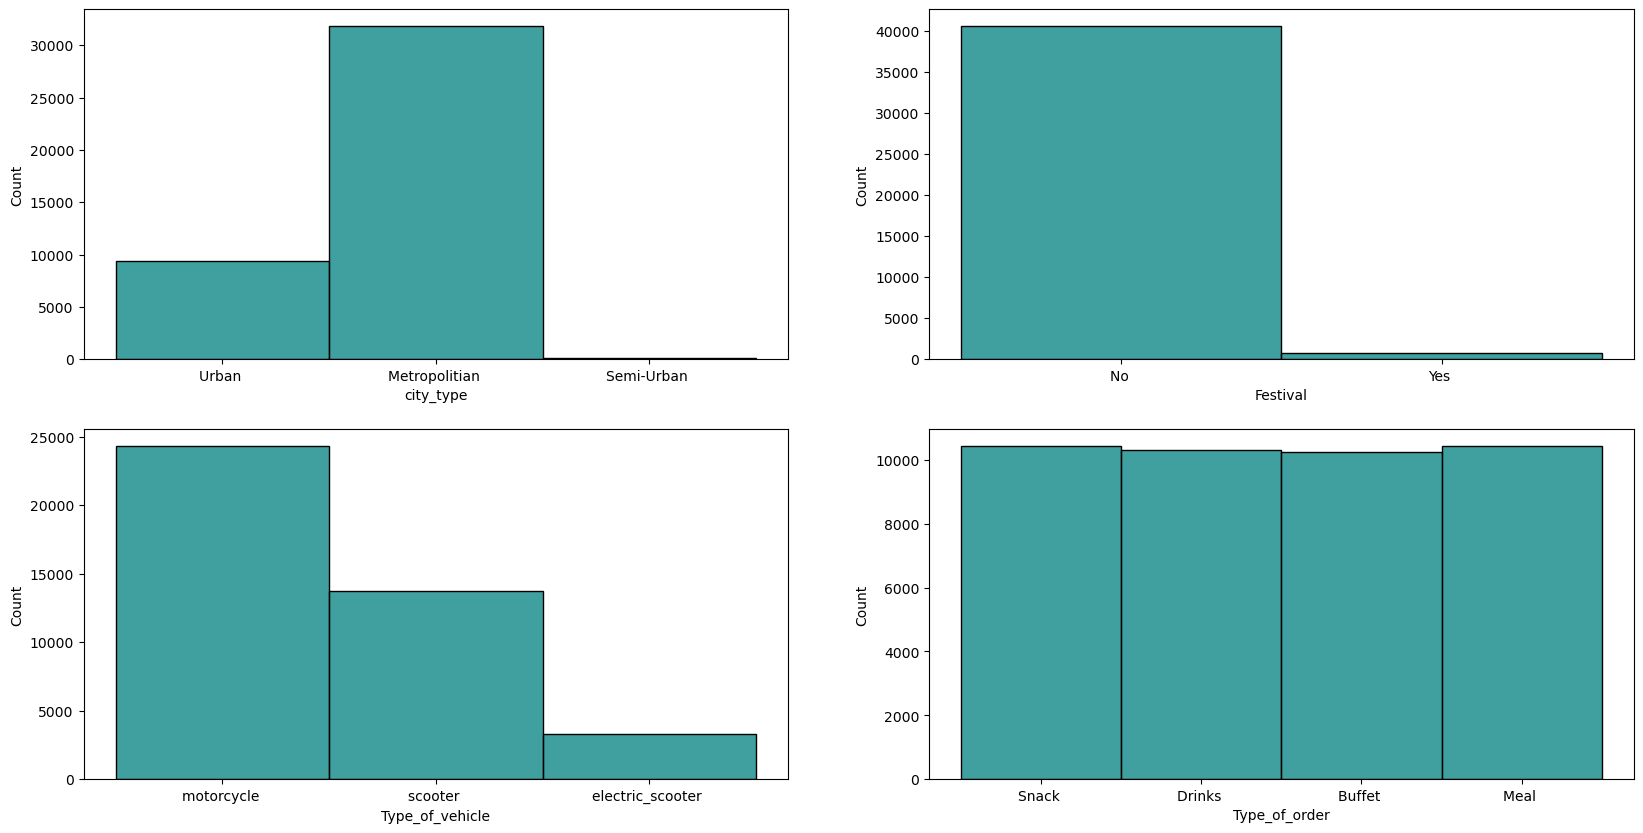

In [59]:
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
ax1 = sns.histplot(x = df['city_type'], color='teal', ax= ax[0, 0])
ax2 = sns.histplot(x = df['Festival'], color='teal', ax= ax[0, 1])
ax3 = sns.histplot(x = df['Type_of_vehicle'], color='teal', ax= ax[1, 0])
ax4 = sns.histplot(x = df['Type_of_order'], color='teal', ax= ax[1, 1])

In [60]:
def cat_num_plot(xcol,ycol):
    sns.set_context('notebook', font_scale = .8)
    plt.figure(figsize=(7, 4))
    ax = sns.barplot(x=xcol, 
                 y=ycol, 
                 palette='viridis',
                 ci = None)
    plt.ylabel('Time Taken');
    
    for p in ax.patches:
        ax.annotate(int(p.get_height()), (p.get_x() + 0.4, p.get_height() + 1), ha = 'center', va = 'bottom', color = 'Black')

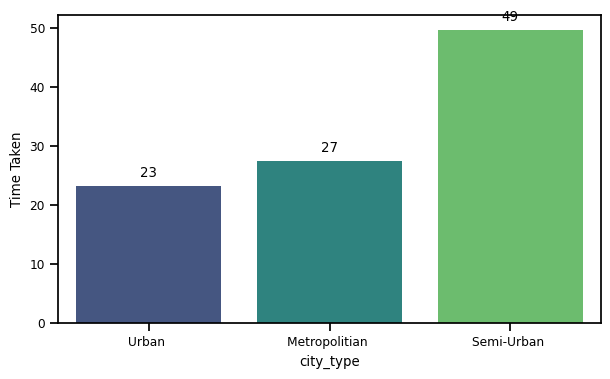

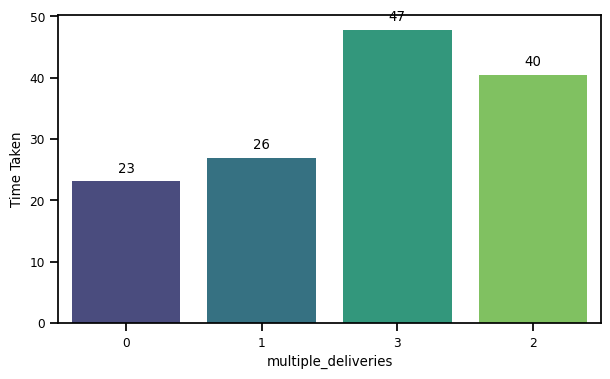

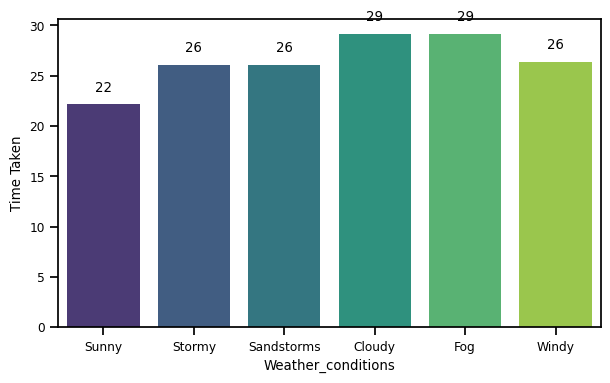

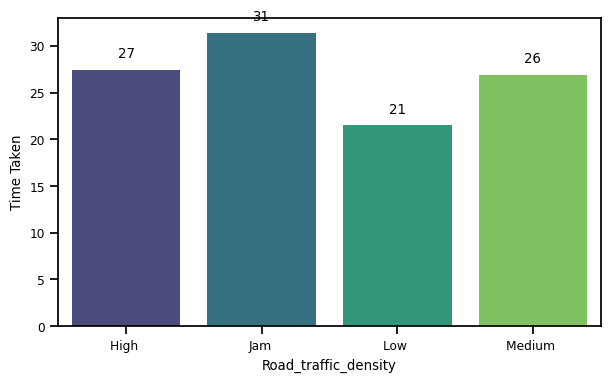

In [61]:
cat_num_plot(df['city_type'],df['Time_taken(min)'])
cat_num_plot(df['multiple_deliveries'],df['Time_taken(min)'])
cat_num_plot(df['Weather_conditions'],df['Time_taken(min)'])
cat_num_plot(df['Road_traffic_density'],df['Time_taken(min)'])

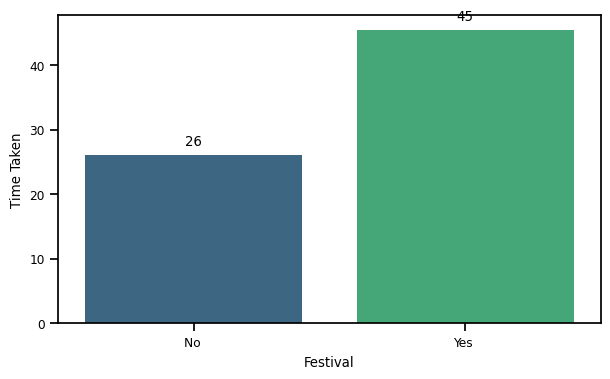

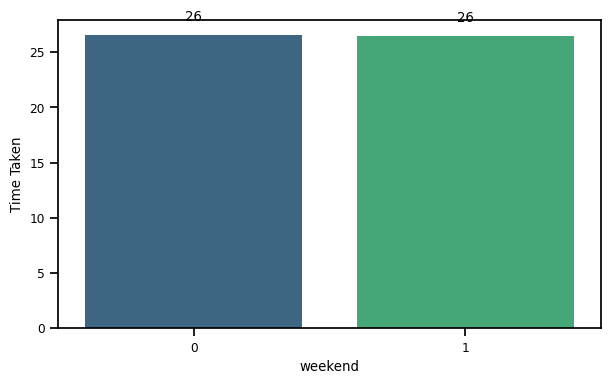

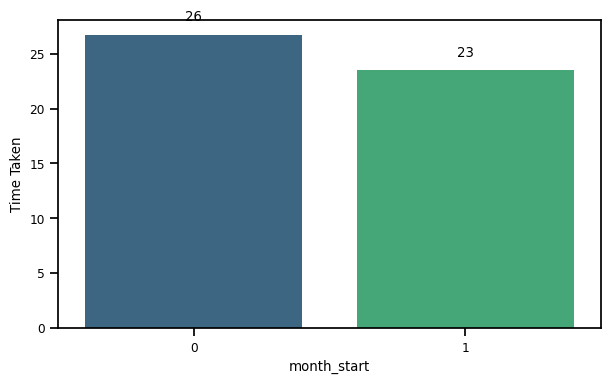

In [62]:
cat_num_plot(df['Festival'],df['Time_taken(min)'])
cat_num_plot(df['weekend'],df['Time_taken(min)'])
cat_num_plot(df['month_start'],df['Time_taken(min)'])

In [63]:
#Age positively affects delivery time
#Delivery time highest for semi-urban ares vis a vis urban and metro
#Multiple delivers negatively affect delivery time
#Delivery times go up during fesivals
#Weekend doesn't affect delivery time
#Road traffic density affects delivery time
#Lowest delivery time during sunny, and highest delivery time during cloudy and stormy
#Lower delivery rating leads to more delivery time

# Preparing Data

In [64]:
def scale_encode_data(df):
    df_num = df.select_dtypes(include="number")
    df_cat = df.select_dtypes(include="object")
    
    #mmscaler = MinMaxScaler()
    #df_num_rescaled = pd.DataFrame(mmscaler.fit_transform(df_num), columns=df_num.columns)
    
    OHE = OneHotEncoder(drop='first')
    df_cat_ohe = pd.DataFrame(OHE.fit_transform(df_cat).toarray(), columns=OHE.get_feature_names_out())
    
    df_num.reset_index(drop=True, inplace=True)
    df_cat_ohe.reset_index(drop=True, inplace=True)
    df_enc = pd.concat([df_num, df_cat_ohe], axis = 1)
    
    return df_enc

In [65]:
df = scale_encode_data(df)

In [66]:
df.shape

(41368, 50)

In [67]:
X = df.drop('Time_taken(min)',axis=1)
y = df['Time_taken(min)']

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [69]:
X_train.shape, X_test.shape

((33094, 49), (8274, 49))

# Checking for Multicollenarity 

In [70]:
X_train_ols = sm.add_constant(X_train)

In [71]:
vif = pd.DataFrame()
vif['Feature'] = X_train_ols.columns
vif['VIF'] = [variance_inflation_factor(X_train_ols.values, i) for i in range(X_train_ols.shape[1])]

# Print the VIF values
print(vif)

                          Feature         VIF
0                           const  381.813324
1             Delivery_person_Age    1.032057
2         Delivery_person_Ratings    1.049663
3                    prepare_time    1.001068
4                        distance    1.024972
5          Weather_conditions_Fog    1.683474
6   Weather_conditions_Sandstorms    1.685062
7       Weather_conditions_Stormy    1.688322
8        Weather_conditions_Sunny    1.672636
9        Weather_conditions_Windy    1.676753
10      Road_traffic_density_Jam     2.932892
11      Road_traffic_density_Low     2.964998
12   Road_traffic_density_Medium     2.646900
13            Vehicle_condition_1    1.754518
14            Vehicle_condition_2    2.304484
15          Type_of_order_Drinks     1.501447
16            Type_of_order_Meal     1.504331
17           Type_of_order_Snack     1.504745
18    Type_of_vehicle_motorcycle     4.727853
19       Type_of_vehicle_scooter     3.767935
20          multiple_deliveries_1 

In [72]:
#Multicollenarity doesn't exist as VIF <10 for all features

# Fitting Model - Linear Regression

In [73]:
X_train.shape, X_test.shape

((33094, 49), (8274, 49))

In [74]:
lrmodel = sm.OLS(y_train, X_train_ols)
results = lrmodel.fit()

In [75]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Time_taken(min)   R-squared:                       0.592
Model:                            OLS   Adj. R-squared:                  0.591
Method:                 Least Squares   F-statistic:                     977.5
Date:                Wed, 28 Jun 2023   Prob (F-statistic):               0.00
Time:                        15:25:14   Log-Likelihood:            -1.0604e+05
No. Observations:               33094   AIC:                         2.122e+05
Df Residuals:                   33044   BIC:                         2.126e+05
Df Model:                          49                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                            55.2112      0.641     86.163      0.000      53.955      56.467
Delivery_person_Age               0.3728      0.006     64.647      0.000       0.362       0.384
Delivery_person_Ratings          -7.5458      0.106    -71.016      0.000      -7.754      -7.337
prepare_time                      0.0011      0.008      0.142      0.887      -0.015       0.017
distance                      -3.384e-05      0.000     -0.306      0.760      -0.000       0.000
Weather_conditions_Fog            0.1104      0.113      0.978      0.328      -0.111       0.332
Weather_conditions_Sandstorms    -2.7195      0.114    -23.835      0.000      -2.943      -2.496
Weather_conditions_Stormy        -2.6710      0.114    -23.497      0.000      -2.894      -2.448
Weather_conditions_Sunny         -6.1320      0.115    -53.119      0.000      -6.358      -5.906
Weather_conditions_Windy         -2.6160      0.114    -22.873      0.000      -2.840      -2.392
Road_traffic_density_Jam          2.5723      0.121     21.342      0.000       2.336       2.809
Road_traffic_density_Low         -5.4291      0.119    -45.477      0.000      -5.663      -5.195
Road_traffic_density_Medium      -0.4676      0.124     -3.768      0.000      -0.711      -0.224
Vehicle_condition_1              -4.5026      0.092    -48.721      0.000      -4.684      -4.321
Vehicle_condition_2              -4.3353      0.106    -41.053      0.000      -4.542      -4.128
Type_of_order_Drinks             -0.0070      0.093     -0.075      0.940      -0.190       0.175
Type_of_order_Meal                0.1090      0.093      1.176      0.240      -0.073       0.291
Type_of_order_Snack               0.1099      0.093      1.186      0.236      -0.072       0.292
Type_of_vehicle_motorcycle        0.1495      0.145      1.033      0.302      -0.134       0.433
Type_of_vehicle_scooter           0.2336      0.135      1.728      0.084      -0.031       0.498
multiple_deliveries_1             2.0134      0.072     27.773      0.000       1.871       2.155
multiple_deliveries_2             8.5595      0.173     49.563      0.000       8.221       8.898
multiple_deliveries_3            12.4902      0.377     33.150      0.000      11.752      13.229
Festival_Yes                      9.0712      0.246     36.846      0.000       8.589       9.554
city_type_Semi-Urban              9.1086      0.556     16.369      0.000       8.018      10.199
city_type_Urban                  -1.9078      0.079    -24.092      0.000      -2.063      -1.753
City_code_ALH                     0.2366      0.362      0.654      0.513      -0.472       0.946
City_code_AURG                   -0.3385      0.364     -0.930      0.352      -1.052       0.375
City_code_BANG                   -0.1790     

In [87]:
lrmodel = LinearRegression()
lrmodel.fit(X_train,y_train)
yhat_train = lrmodel.predict(X_train)
yhat_test = lrmodel.predict(X_test)

train_mape = mape(y_train,yhat_train)
test_mape = mape(y_test,yhat_test)
train_rmse = np.sqrt(mean_squared_error(y_train,yhat_train))
test_rmse = np.sqrt(mean_squared_error(y_test,yhat_test))

print('train mape:', train_mape)
print('test mape:', test_mape)
print('train rmse:', train_rmse)
print('test rmse:', test_rmse)

train mape: 0.20694244261403097
test mape: 0.20759315680179244
train rmse: 5.961079379229259
test rmse: 5.966627935523831


In [81]:
from mlxtend.feature_selection import SequentialFeatureSelector

lrmodel = LinearRegression()
selector = SequentialFeatureSelector(lrmodel, k_features='best', forward=True, scoring='r2', cv=3)
selector.fit(X_train, y_train)
selected_feature_indices = selector.k_feature_idx_
selected_features = X.columns[list(selected_feature_indices)]

In [83]:
selected_features, len(selected_features)

(Index(['Delivery_person_Age', 'Delivery_person_Ratings',
        'Weather_conditions_Fog', 'Weather_conditions_Sandstorms',
        'Weather_conditions_Stormy', 'Weather_conditions_Sunny',
        'Weather_conditions_Windy', 'Road_traffic_density_Jam ',
        'Road_traffic_density_Low ', 'Road_traffic_density_Medium ',
        'Vehicle_condition_1', 'Vehicle_condition_2',
        'Type_of_vehicle_motorcycle ', 'Type_of_vehicle_scooter ',
        'multiple_deliveries_1', 'multiple_deliveries_2',
        'multiple_deliveries_3', 'Festival_Yes ', 'city_type_Semi-Urban ',
        'city_type_Urban ', 'City_code_ALH', 'City_code_AURG', 'City_code_DEH',
        'City_code_JAP', 'City_code_KOC', 'City_code_LUDH', 'City_code_MUM',
        'City_code_VAD', 'month_start_1', 'month_end_1'],
       dtype='object'),
 30)

In [84]:
X_train_filtered = X_train[selected_features]
X_test_filtered = X_test[selected_features]

In [88]:
lrmodel = LinearRegression()
lrmodel.fit(X_train_filtered,y_train)
yhat_train = lrmodel.predict(X_train_filtered)
yhat_test = lrmodel.predict(X_test_filtered)

train_mape = mape(y_train,yhat_train)
test_mape = mape(y_test,yhat_test)
train_rmse = np.sqrt(mean_squared_error(y_train,yhat_train))
test_rmse = np.sqrt(mean_squared_error(y_test,yhat_test))

print('train mape:', train_mape)
print('test mape:', test_mape)
print('train rmse:', train_rmse)
print('test rmse:', test_rmse)

train mape: 0.20699988641399325
test mape: 0.2075276849137359
train rmse: 5.962032643197058
test rmse: 5.964211323154455


# Random Forest

In [90]:
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)
yhat_train = rf_model.predict(X_train)
yhat_test = rf_model.predict(X_test)

train_mape = mape(y_train,yhat_train)
test_mape = mape(y_test,yhat_test)
train_rmse = np.sqrt(mean_squared_error(y_train,yhat_train))
test_rmse = np.sqrt(mean_squared_error(y_test,yhat_test))

print('train mape:', train_mape)
print('test mape:', test_mape)
print('train rmse:', train_rmse)
print('test rmse:', test_rmse)

train mape: 0.049410858922192054
test mape: 0.1330082582296735
train rmse: 1.4627929521679337
test rmse: 3.880247058363744


In [96]:
from sklearn.metrics import mean_absolute_error, make_scorer

rf_model = RandomForestRegressor(random_state=42,n_estimators=50)
scorer = make_scorer(mean_absolute_error, greater_is_better=False)
selector = SequentialFeatureSelector(rf_model, k_features='best', forward=True, scoring=scorer, cv=3,n_jobs=-1)
selector.fit(X_train, y_train)
selected_feature_indices = selector.k_feature_idx_
selected_features = X.columns[list(selected_feature_indices)]

In [98]:
selected_features, len(selected_features)

(Index(['Delivery_person_Age', 'Delivery_person_Ratings', 'prepare_time',
        'distance', 'Weather_conditions_Fog', 'Weather_conditions_Sandstorms',
        'Weather_conditions_Stormy', 'Weather_conditions_Sunny',
        'Weather_conditions_Windy', 'Road_traffic_density_Low ',
        'Road_traffic_density_Medium ', 'Vehicle_condition_1',
        'Vehicle_condition_2', 'Type_of_order_Drinks ', 'Type_of_order_Meal ',
        'Type_of_vehicle_motorcycle ', 'Type_of_vehicle_scooter ',
        'multiple_deliveries_1', 'multiple_deliveries_2',
        'multiple_deliveries_3', 'Festival_Yes ', 'city_type_Semi-Urban ',
        'City_code_ALH', 'City_code_AURG', 'City_code_BANG', 'City_code_DEH',
        'City_code_HYD', 'City_code_KOC', 'City_code_KOL', 'City_code_LUDH',
        'City_code_MUM', 'City_code_RANCHI', 'City_code_VAD', 'weekend_1',
        'month_start_1', 'month_end_1'],
       dtype='object'),
 36)

In [99]:
X_train_filtered = X_train[selected_features]
X_test_filtered = X_test[selected_features]

In [108]:
from random import randint
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'n_estimators': [randint(50, 500)],
    'max_depth': [randint(3, 100)],
    'min_samples_split': [randint(2, 50)],
    'min_samples_leaf': [randint(1, 50)],
}

rf_model = RandomForestRegressor(random_state=42)
scorer = make_scorer(mean_absolute_error, greater_is_better=False)
random_search = RandomizedSearchCV(rf_model, param_distributions=param_grid,scoring=scorer, n_iter=15, cv=3)
random_search.fit(X_train_filtered, y_train)
print("Best Parameters:", random_search.best_params_)

Best Parameters: {'n_estimators': 429, 'min_samples_split': 18, 'min_samples_leaf': 5, 'max_depth': 16}


In [ ]:
Using the Best Model

In [109]:
best_rf_model = RandomForestRegressor(**random_search.best_params_)
best_rf_model.fit(X_train_filtered, y_train)
yhat_train = best_rf_model.predict(X_train_filtered)
yhat_test = best_rf_model.predict(X_test_filtered)

train_mape = mape(y_train,yhat_train)
test_mape = mape(y_test,yhat_test)
train_rmse = np.sqrt(mean_squared_error(y_train,yhat_train))
test_rmse = np.sqrt(mean_squared_error(y_test,yhat_test))

print('train mape:', train_mape)
print('test mape:', test_mape)
print('train rmse:', train_rmse)
print('test rmse:', test_rmse)

train mape: 0.10732850140092041
test mape: 0.13087336143188982
train rmse: 3.1599034332710754
test rmse: 3.7765262880673967


# KNN

In [110]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
mape(y_test,yhat_test)

0.13087336143188982

In [113]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

# Create the KNN regressor object
knn = KNeighborsRegressor()

# Perform grid search
grid_search = GridSearchCV(knn, param_grid, cv=3)
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Parameters: {'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
Best Score: 0.558094393992432


In [114]:
knn = KNeighborsRegressor(**grid_search.best_params_)
knn.fit(X_train, y_train)
yhat_train = knn.predict(X_train)
yhat_test = knn.predict(X_test)

train_mape = mape(y_train,yhat_train)
test_mape = mape(y_test,yhat_test)
train_rmse = np.sqrt(mean_squared_error(y_train,yhat_train))
test_rmse = np.sqrt(mean_squared_error(y_test,yhat_test))

print('train mape:', train_mape)
print('test mape:', test_mape)
print('train rmse:', train_rmse)
print('test rmse:', test_rmse)

train mape: 4.8435843677152994e-05
test mape: 0.20848937734304654
train rmse: 0.07646555646773327
test rmse: 6.084452888951712
